In [4]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten, InputLayer, Reshape
from tensorflow.keras.layers import BatchNormalization, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import losses
import tensorflow as tf
import numpy as np
import os,random
import cv2
import os
from tensorflow.compat.v1.keras import backend as K
import matplotlib.pyplot as plt
from mtcnn.mtcnn import MTCNN

%matplotlib inline

Using TensorFlow backend.


In [5]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.90
K.set_session(tf.compat.v1.Session(config=config))
detector = MTCNN()

In [6]:
def load_data(input_path, channels=3):
    all_files = sorted([f for f in os.listdir(input_path) \
                if os.path.isfile(os.path.join(input_path, f))])
    
    X = np.zeros((0, img_height, img_width, channels), dtype=np.float32)
    for file in all_files:
        image_path = os.path.join(input_path, file)
        if channels==3:
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = face(img)
            if img is None:
                continue
            img = cv2.resize(img, (img_height, img_height))
        else:
            img = cv2.imread(image_path, 0)
            img = cv2.resize(img, (img_height, img_height))
            img = np.expand_dims(img, axis=2)
        img = img/255.
        img = np.expand_dims(img, axis=0).astype(np.float32)
        X = np.concatenate((X, img), axis=0)
    return X

def face(frame):
    results = detector.detect_faces(frame)
    if not len(results):
        return None
    for result in results:
        bounding_box = result['box']
        x, y, h, w = [max(box,0) for box in bounding_box]
        face = frame[y:y+w, x:x+h, :]
        break
    return face

In [7]:
class Generator(Model):
    
    def __init__(self, input_shape=256):
        super(Generator, self).__init__(name='Generator')
        
        self.code = Dense(16*16*4)
        self.reshape = Reshape((16, 16, 4))

        self.decov0 = Conv2DTranspose(64, (5, 5), strides=(2,2), padding='same', activation='elu')
        self.decov1 = Conv2DTranspose(64, (5, 5), strides=(2,2), padding='same', activation='elu')
        self.decov2 = Conv2DTranspose(32, (3, 3), strides=(2,2), padding='same', activation='elu')
        self.decov3 = Conv2DTranspose(3, (3, 3), strides=(1,1), padding='same', activation=None)
        self.elu = Activation("elu")
        self.sigmoid = Activation("sigmoid")

    def call(self, x):
        
        x = self.code(x)
        
        x = self.reshape(x)
        
        x = self.elu(x)
        
        x = self.decov0(x)
        x = self.decov1(x)
        x = self.decov2(x)
        x = self.decov3(x)
        x = self.sigmoid(x)

        return x

In [21]:
shape = (None, 256)
network = Generator()
network.build(input_shape=shape)

In [22]:
input_path = 'data'
img_height, img_width = (128, 128)
# Y = load_data(input_path)
# np.save('data.npy', Y)
Y = np.load('data.npy')
X = np.random.normal(size=(Y.shape[0], 256)).astype('float32')

In [25]:
network.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
network.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              multiple                  263168    
_________________________________________________________________
reshape_1 (Reshape)          multiple                  0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr multiple                  6464      
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr multiple                  102464    
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr multiple                  18464     
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr multiple                  867       
_________________________________________________________________
activation_2 (Activation)    multiple                  0 

In [26]:
network.fit(X, Y, epochs=500, batch_size=128, shuffle=True)

Train on 448 samples
Epoch 1/500
448/448 [==============================] - 1s 2ms/sample - loss: 0.0654 - accuracy: 0.4405
Epoch 2/500
448/448 [==============================] - 0s 837us/sample - loss: 0.0609 - accuracy: 0.7479
Epoch 3/500
448/448 [==============================] - 0s 844us/sample - loss: 0.0530 - accuracy: 0.8674
Epoch 4/500
448/448 [==============================] - 0s 843us/sample - loss: 0.0491 - accuracy: 0.8963
Epoch 5/500
448/448 [==============================] - 0s 844us/sample - loss: 0.0460 - accuracy: 0.9100
Epoch 6/500
448/448 [==============================] - 0s 841us/sample - loss: 0.0432 - accuracy: 0.9082
Epoch 7/500
448/448 [==============================] - 0s 844us/sample - loss: 0.0403 - accuracy: 0.8913
Epoch 8/500
448/448 [==============================] - 0s 843us/sample - loss: 0.0373 - accuracy: 0.8597
Epoch 9/500
448/448 [==============================] - 0s 847us/sample - loss: 0.0349 - accuracy: 0.8314
Epoch 10/500
448/448 [==============

448/448 [==============================] - 0s 868us/sample - loss: 0.0088 - accuracy: 0.9229
Epoch 79/500
448/448 [==============================] - 0s 859us/sample - loss: 0.0088 - accuracy: 0.9234
Epoch 80/500
448/448 [==============================] - 0s 860us/sample - loss: 0.0088 - accuracy: 0.9242
Epoch 81/500
448/448 [==============================] - 0s 865us/sample - loss: 0.0088 - accuracy: 0.9239
Epoch 82/500
448/448 [==============================] - 0s 856us/sample - loss: 0.0087 - accuracy: 0.9237
Epoch 83/500
448/448 [==============================] - 0s 861us/sample - loss: 0.0087 - accuracy: 0.9237
Epoch 84/500
448/448 [==============================] - 0s 864us/sample - loss: 0.0086 - accuracy: 0.9238
Epoch 85/500
448/448 [==============================] - 0s 861us/sample - loss: 0.0086 - accuracy: 0.9234
Epoch 86/500
448/448 [==============================] - 0s 870us/sample - loss: 0.0087 - accuracy: 0.9235
Epoch 87/500
448/448 [==============================] - 0s 

448/448 [==============================] - 0s 868us/sample - loss: 0.0072 - accuracy: 0.9226
Epoch 155/500
448/448 [==============================] - 0s 864us/sample - loss: 0.0072 - accuracy: 0.9225
Epoch 156/500
448/448 [==============================] - 0s 868us/sample - loss: 0.0072 - accuracy: 0.9217
Epoch 157/500
448/448 [==============================] - 0s 868us/sample - loss: 0.0072 - accuracy: 0.9223
Epoch 158/500
448/448 [==============================] - 0s 870us/sample - loss: 0.0072 - accuracy: 0.9216
Epoch 159/500
448/448 [==============================] - 0s 867us/sample - loss: 0.0072 - accuracy: 0.9233
Epoch 160/500
448/448 [==============================] - 0s 868us/sample - loss: 0.0072 - accuracy: 0.9220
Epoch 161/500
448/448 [==============================] - 0s 869us/sample - loss: 0.0072 - accuracy: 0.9222
Epoch 162/500
448/448 [==============================] - 0s 868us/sample - loss: 0.0072 - accuracy: 0.9213
Epoch 163/500
448/448 [============================

448/448 [==============================] - 0s 870us/sample - loss: 0.0065 - accuracy: 0.9247
Epoch 231/500
448/448 [==============================] - 0s 871us/sample - loss: 0.0065 - accuracy: 0.9242
Epoch 232/500
448/448 [==============================] - 0s 876us/sample - loss: 0.0065 - accuracy: 0.9247
Epoch 233/500
448/448 [==============================] - 0s 876us/sample - loss: 0.0065 - accuracy: 0.9247
Epoch 234/500
448/448 [==============================] - 0s 877us/sample - loss: 0.0064 - accuracy: 0.9247
Epoch 235/500
448/448 [==============================] - 0s 872us/sample - loss: 0.0065 - accuracy: 0.9245
Epoch 236/500
448/448 [==============================] - 0s 866us/sample - loss: 0.0065 - accuracy: 0.9252
Epoch 237/500
448/448 [==============================] - 0s 870us/sample - loss: 0.0065 - accuracy: 0.9249
Epoch 238/500
448/448 [==============================] - 0s 874us/sample - loss: 0.0064 - accuracy: 0.9253
Epoch 239/500
448/448 [============================

448/448 [==============================] - 0s 881us/sample - loss: 0.0058 - accuracy: 0.9290
Epoch 307/500
448/448 [==============================] - 0s 892us/sample - loss: 0.0058 - accuracy: 0.9294
Epoch 308/500
448/448 [==============================] - 0s 889us/sample - loss: 0.0057 - accuracy: 0.9291
Epoch 309/500
448/448 [==============================] - 0s 874us/sample - loss: 0.0057 - accuracy: 0.9295
Epoch 310/500
448/448 [==============================] - 0s 875us/sample - loss: 0.0057 - accuracy: 0.9296
Epoch 311/500
448/448 [==============================] - 0s 878us/sample - loss: 0.0057 - accuracy: 0.9295
Epoch 312/500
448/448 [==============================] - 0s 878us/sample - loss: 0.0057 - accuracy: 0.9295
Epoch 313/500
448/448 [==============================] - 0s 873us/sample - loss: 0.0057 - accuracy: 0.9299
Epoch 314/500
448/448 [==============================] - 0s 877us/sample - loss: 0.0057 - accuracy: 0.9296
Epoch 315/500
448/448 [============================

448/448 [==============================] - 0s 893us/sample - loss: 0.0054 - accuracy: 0.9335
Epoch 383/500
448/448 [==============================] - 0s 876us/sample - loss: 0.0053 - accuracy: 0.9340
Epoch 384/500
448/448 [==============================] - 0s 898us/sample - loss: 0.0054 - accuracy: 0.9338
Epoch 385/500
448/448 [==============================] - 0s 886us/sample - loss: 0.0054 - accuracy: 0.9339
Epoch 386/500
448/448 [==============================] - 0s 884us/sample - loss: 0.0053 - accuracy: 0.9340
Epoch 387/500
448/448 [==============================] - 0s 879us/sample - loss: 0.0053 - accuracy: 0.9342
Epoch 388/500
448/448 [==============================] - 0s 877us/sample - loss: 0.0053 - accuracy: 0.9343
Epoch 389/500
448/448 [==============================] - 0s 878us/sample - loss: 0.0053 - accuracy: 0.9339
Epoch 390/500
448/448 [==============================] - 0s 885us/sample - loss: 0.0053 - accuracy: 0.9338
Epoch 391/500
448/448 [============================

448/448 [==============================] - 0s 881us/sample - loss: 0.0050 - accuracy: 0.9370
Epoch 459/500
448/448 [==============================] - 0s 878us/sample - loss: 0.0050 - accuracy: 0.9372
Epoch 460/500
448/448 [==============================] - 0s 880us/sample - loss: 0.0050 - accuracy: 0.9374
Epoch 461/500
448/448 [==============================] - 0s 895us/sample - loss: 0.0050 - accuracy: 0.9370
Epoch 462/500
448/448 [==============================] - 0s 881us/sample - loss: 0.0050 - accuracy: 0.9374
Epoch 463/500
448/448 [==============================] - 0s 880us/sample - loss: 0.0049 - accuracy: 0.9373
Epoch 464/500
448/448 [==============================] - 0s 881us/sample - loss: 0.0049 - accuracy: 0.9372
Epoch 465/500
448/448 [==============================] - 0s 881us/sample - loss: 0.0049 - accuracy: 0.9375
Epoch 466/500
448/448 [==============================] - 0s 881us/sample - loss: 0.0049 - accuracy: 0.9372
Epoch 467/500
448/448 [============================

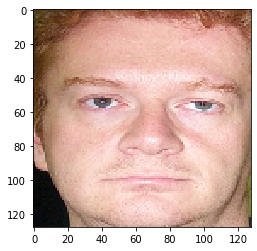

In [40]:
plt.imshow(Y[32])

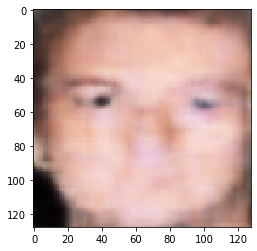

In [41]:
mu, sigma = (0, 0.5)
# a = np.random.normal(size=(256))
a = X[32]
p = network.predict(np.expand_dims(a, axis=0).astype(np.float32))
plt.imshow(p.squeeze())